In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [68]:
#Roller dimensions:
OD = 101.6 # 4" in mm
ID = 76.2 + (2*0.254) # 3" in mm, oversized by 0.020"
roller_height = 153*3 #~6" in mm *2 = 12"

#key dimenions:
key_rad = 5.842-(4.0*0.254) #0.230" in mm, underersized by 0.040"
key_w = 12.446-(4.0*0.254) # 0.490" in mm, undersized by 0.040"

0.5
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Text(0, 0.5, 'Height (mm)')

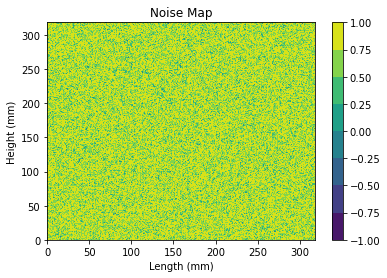

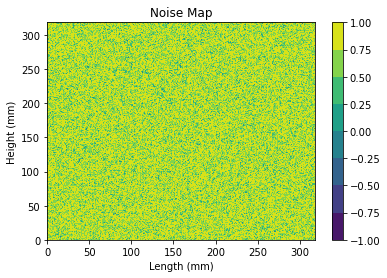

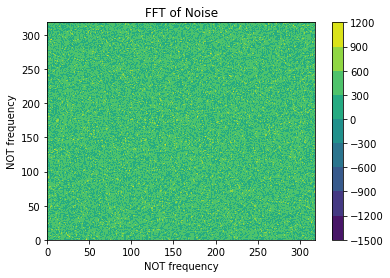

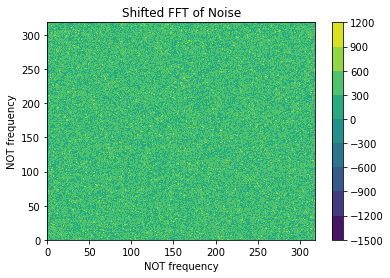

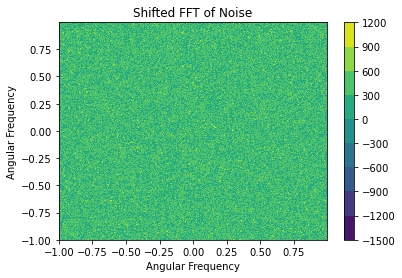

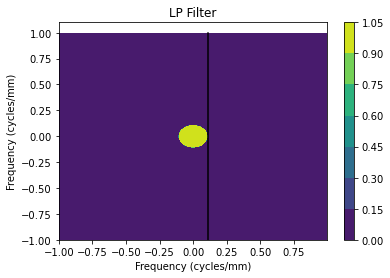

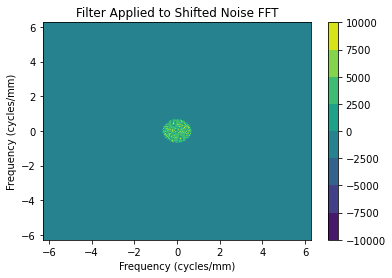

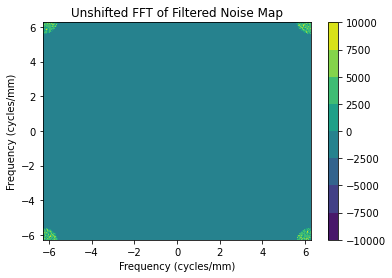

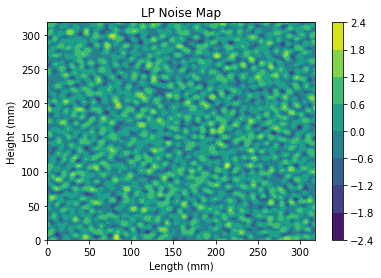

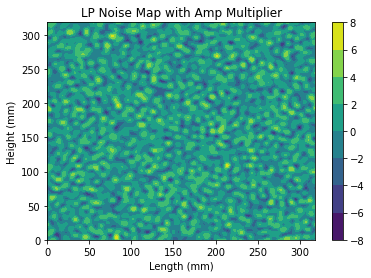

In [69]:
#Copied from Jared's code: 
### INITIALIZE ###
L = int(OD*np.pi) # circumference from OD
#print(L)
H = L  # Length of roller 
Nl = L * 2 #would L*2 be the Nyquist?
Nh = H * 2
dL = L/Nl #space between sample points
dH = H/Nh #these are equal - as they should be (?)
#print(dL,dH)
f = 100 #Hz or cycles/mm 75 works well for visualization
wc = (f / (2*np.pi))*(L/153.0) #rad/sec or rad/mm 
amp = 1 #amplitude +/- of noise
desired_featuresize = 5 #mm across
safety_mult = 2.8 #Extra multiplier term to even further increase % of 45deg facets

x = np.arange(0,L,dL)
y = np.arange(0,H,dH)
X,Y = np.meshgrid(x,y)

### ESTABLISH NOISE MAP ###
wn2d = np.random.uniform(-amp,amp,(Nh,Nl))
plt.figure()
plt.contourf(X,Y,wn2d)
plt.colorbar()
plt.title("Noise Map")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")

### MAKE A PLANE WAVE ###

#wn2d = amp * np.sin(0.15 * Y) #########################
plt.figure()
plt.contourf(X,Y,wn2d)
plt.colorbar()
plt.title("Noise Map")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")

### TAKE 2D FFT ###
wn2d_fft = np.fft.fft2(wn2d)
plt.figure()
plt.contourf(X,Y,wn2d_fft)
plt.colorbar()
plt.title("FFT of Noise")
plt.xlabel("NOT frequency")
plt.ylabel("NOT frequency")

### SHIFT THE FFT TO 0 ###
wn2d_shift = np.fft.fftshift(wn2d_fft)
plt.figure()
plt.contourf(X,Y,wn2d_shift)
plt.colorbar()
plt.title("Shifted FFT of Noise")
plt.xlabel("NOT frequency")
plt.ylabel("NOT frequency")

### CONVERT TO FERQUENCY AXIS DOMAIN ### I SUSPECT HERE IS WHERE THE ASYMMETRY HAPPENS
#freq bins - THESE NEED CHECKED
print(dL)
#freqs = np.fft.fftfreq((len(x),len(y)))
freqx = np.fft.fftshift(np.fft.fftfreq(x.shape[0],dL))
freqy = np.fft.fftshift(np.fft.fftfreq(y.shape[0],dH))
fX,fY = np.meshgrid(freqx, freqy)
#print(freqx)
#print(freqy)
plt.figure()
plt.contourf(fX,fY,wn2d_shift)
plt.colorbar()
plt.title("Shifted FFT of Noise")
plt.xlabel("Angular Frequency")
plt.ylabel("Angular Frequency")

### MAKE THE LP FILTER ###
#make lp filter
rows, cols = wn2d.shape
crow, ccol = int(rows/2), int(cols/2)
#lpf = np.zeros((rows, cols, 2))
lpf = np.zeros((rows, cols))
center = [crow, ccol]
xlpf, ylpf = np.ogrid[:rows, :cols]
lpf_area = (xlpf - center[0])**2 + (ylpf - center[1])**2 <= wc**2
lpf[lpf_area] = 1
#lpf = np.ones((Nl,Nh)) ############################ THIS CAN BE UNCOMMENTED TO STOP FILTER
print(lpf_area)
print(lpf)
plt.figure()
plt.contourf(freqx,freqy,lpf) #scaled from angular freq to Hz
plt.plot([0.111, 0.111], [-1, 1], '-k')
plt.colorbar()
plt.title("LP Filter")
plt.xlabel("Frequency (cycles/mm)")
plt.ylabel("Frequency (cycles/mm)")

### APPLY THE FILTER TO THE SHIFTED FFT ###
fftwn2d_lp = lpf*wn2d_shift * 10 ###THIS MULTIPLIER HERE WILL CHANGE THE DERIV CALC
plt.figure()
plt.contourf(2*np.pi*fX, 2*np.pi*fY, fftwn2d_lp)
plt.colorbar()
plt.title("Filter Applied to Shifted Noise FFT")
plt.xlabel("Frequency (cycles/mm)")
plt.ylabel("Frequency (cycles/mm)")

### UNSHIFT THE FILTERED FFT ###
fftwn2d_lp_unshift = np.fft.ifftshift(fftwn2d_lp)
plt.figure()
plt.contourf(2*np.pi*fX, 2*np.pi*fY, fftwn2d_lp_unshift)
plt.colorbar()
plt.title("Unshifted FFT of Filtered Noise Map")
plt.xlabel("Frequency (cycles/mm)")
plt.ylabel("Frequency (cycles/mm)")

### TAKE THE INVERSE FFT TO GET A FILTERED SIGNAL BACK ###
wn2d_lp = np.fft.ifft2(fftwn2d_lp_unshift)
plt.figure()
plt.contourf(X,Y,wn2d_lp)
plt.colorbar()
plt.title("LP Noise Map")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")

### AMPLIFYING FEATURE SIZES TO INCREASE DERIVATIVES ###
#for significant % of 45deg derivatives
scale = desired_featuresize / 2
map_max = np.amax(np.abs(wn2d_lp))
multiplier = scale / map_max
wn2d_lp = wn2d_lp * multiplier * safety_mult
plt.figure()
plt.contourf(X,Y,wn2d_lp)
plt.colorbar()
plt.title("LP Noise Map with Amp Multiplier")
plt.xlabel("Length (mm)")
plt.ylabel("Height (mm)")

In [70]:
wn2d_lp = np.real(wn2d_lp)

In [71]:
#Creating inverse noise surface:
wn2d_lp_inv = -1.0*wn2d_lp

In [72]:
#Creating cylindrical nosie surface

roller_rad = OD/2.0
phi = np.linspace(0,2*np.pi,np.shape(X)[1])

XC = np.empty_like(X)
YC = np.empty_like(Y)
ZC = np.empty_like(wn2d_lp)

i=0
j=0

while i<np.shape(X)[0]:
    j=0
    while j<np.shape(X)[1]:
        XC[i][j]= (roller_rad+wn2d_lp[i][j])*np.cos(phi[j]) 
        YC[i][j]= (roller_rad+wn2d_lp[i][j])*np.sin(phi[j])
        ZC[i][j]= Y[i][j]
        j+=1
    i+=1
    

XC_2 = np.empty_like(XC)
YC_2 = np.empty_like(YC)
ZC_2 = np.empty_like(ZC)
i=0
j=0
while i<np.shape(X)[0]:
    j=0
    while j<np.shape(X)[1]:
        XC_2[i][j] = XC[i][j]
        YC_2[i][j] = YC[i][j]
        ZC_2[i][j] = ZC[i][j]+ZC[-1][-1]
        j+=1
    i+=1
    
XC_3 = np.empty_like(XC)
YC_3 = np.empty_like(YC)
ZC_3 = np.empty_like(ZC)
i=0
j=0
while i<np.shape(X)[0]:
    j=0
    while j<np.shape(X)[1]:
        XC_3[i][j] = XC[i][j]
        YC_3[i][j] = YC[i][j]
        ZC_3[i][j] = ZC[i][j]+ZC_2[-1][-1]
        j+=1
    i+=1
    
XC_tot = np.concatenate((XC,XC_2,XC_3))
YC_tot = np.concatenate((YC,YC_2,YC_3))
ZC_tot = np.concatenate((ZC,ZC_2,ZC_3))


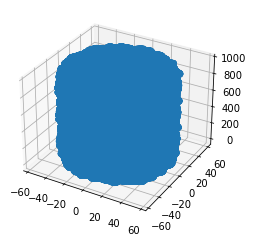

In [73]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.scatter(XC,YC,ZC)
#ax.scatter(XC_2,YC_2,ZC_2)
#ax.scatter(XC_3,YC_3,ZC_3)
ax.scatter(XC_tot,YC_tot,ZC_tot)

In [74]:
XC_inv = np.empty_like(X)
YC_inv = np.empty_like(Y)
ZC_inv = np.empty_like(wn2d_lp_inv)

i=0
j=0
p=len(phi)-1

while i<np.shape(X)[0]:
    j=0
    p=len(phi)-1
    while j<np.shape(X)[1]:
        XC_inv[i][j]= (roller_rad+wn2d_lp_inv[i][j])*np.cos(phi[p])
        YC_inv[i][j]= (roller_rad+wn2d_lp_inv[i][j])*np.sin(phi[p]) 
        ZC_inv[i][j]= Y[i][j]
        j+=1
        p-=1
    i+=1
    
XC_inv_2 = np.empty_like(XC_inv)
YC_inv_2 = np.empty_like(YC_inv)
ZC_inv_2 = np.empty_like(ZC_inv)
i=0
j=0
while i<np.shape(X)[0]:
    j=0
    while j<np.shape(X)[1]:
        XC_inv_2[i][j] = XC_inv[i][j]
        YC_inv_2[i][j] = YC_inv[i][j]
        ZC_inv_2[i][j] = ZC_inv[i][j]+ZC_inv[-1][-1]
        j+=1
    i+=1
    
XC_inv_3 = np.empty_like(XC_inv)
YC_inv_3 = np.empty_like(YC_inv)
ZC_inv_3 = np.empty_like(ZC_inv)
i=0
j=0
while i<np.shape(X)[0]:
    j=0
    while j<np.shape(X)[1]:
        XC_inv_3[i][j] = XC_inv[i][j]
        YC_inv_3[i][j] = YC_inv[i][j]
        ZC_inv_3[i][j] = ZC_inv[i][j]+ZC_inv_2[-1][-1]
        j+=1
    i+=1
    
XC_inv_tot = np.concatenate((XC_inv,XC_inv_2,XC_inv_3))
YC_inv_tot = np.concatenate((YC_inv,YC_inv_2,YC_inv_3))
ZC_inv_tot = np.concatenate((ZC_inv,ZC_inv_2,ZC_inv_3))


In [75]:
#Creating walls of cylindrical noise surface: 

x_wall = []
y_wall = []
z_wall = []

i=0
j=0

#Creating inner wall:
while i<np.shape(YC_tot)[0]:
    j=0
    while j<np.shape(YC_tot)[1]:
        x_wall.append((ID/2.0)*np.cos(phi[j]))
        y_wall.append((ID/2.0)*np.sin(phi[j]))
        z_wall.append(ZC_tot[i][j])
        j+=1
    i+=1

i=0
k=0.5

#Creating top and botom surfaces
while i<np.shape(YC_tot)[1]:
    k=0.5
    while roller_rad-k>ID/2.0:
        x_wall.append((roller_rad-k)*np.cos(phi[i]))
        y_wall.append((roller_rad-k)*np.sin(phi[i]))
        z_wall.append(0)
        x_wall.append((roller_rad-k)*np.cos(phi[i]))
        y_wall.append((roller_rad-k)*np.sin(phi[i]))
        z_wall.append(roller_height)
        k+=0.5      
    i+=1

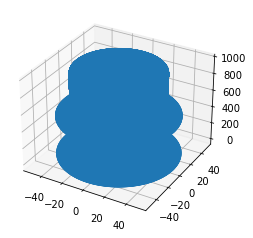

In [76]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_wall,y_wall,z_wall)

In [77]:
#making key:
x_key = []
y_key = []
z_key = []

i=0
j=(ID/2.0)+2
k=-key_w/2.0
step = 0.5

#left and right walls
while i<=roller_height:
    j=(ID/2.0)+2
    while j>=(ID/2.0)-key_rad:
        x_key.append(-key_w/2.0)
        y_key.append(j)
        z_key.append(i)
        x_key.append(key_w/2.0)
        y_key.append(j)
        z_key.append(i)
        j-=step
    i+=step

#top and bottom
j=(ID/2.0)+2
while j>=(ID/2.0)-key_rad:
    k=-key_w/2.0
    while k<=key_w/2.0:
        x_key.append(k)
        y_key.append(j)
        z_key.append(0)
        x_key.append(k)
        y_key.append(j)
        z_key.append(roller_height)  
        k+=step
    j-=step

inner_j = y_key[-1]
print(inner_j)

#front wall
i=0
while i<=roller_height:
    k=-key_w/2.0
    while k<=key_w/2.0:
        x_key.append(k)
        y_key.append(inner_j)
        z_key.append(i)
        k+=step
    i+=step

33.854


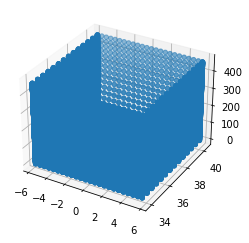

In [78]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_key,y_key,z_key)

In [81]:
f = open("roller_18in.txt",'w')

i=0
j=0

while i<np.shape(XC_tot)[0]:
    j=0
    while j<np.shape(XC_tot)[1]:
        if ZC_tot[i][j]<=roller_height:
            f.write(str(XC_tot[i][j])+" "+str(YC_tot[i][j])+" "+str(ZC_tot[i][j])+'\n')
        j+=1    
    i+=1
    
k=0
while k<len(x_wall):
    if z_wall[k]<=roller_height:
        f.write(str(x_wall[k])+" "+str(y_wall[k])+" "+str(z_wall[k])+"\n")
    k+=1
    
l=0
while l<len(x_key):
    f.write(str(x_key[l])+" "+str(y_key[l])+" "+str(z_key[l])+"\n")
    l+=1

f.close()

In [82]:
f = open("roller_18in_inv.txt",'w')

i=0
j=0

while i<np.shape(XC_inv_tot)[0]:
    j=0
    while j<np.shape(XC_tot)[1]:
        if ZC_inv_tot[i][j]<=roller_height:
            f.write(str(XC_inv_tot[i][j])+" "+str(YC_inv_tot[i][j])+" "+str(ZC_inv_tot[i][j])+'\n')
        j+=1    
    i+=1
    
k=0
while k<len(x_wall):
    if z_wall[k]<=roller_height:
        f.write(str(x_wall[k])+" "+str(y_wall[k])+" "+str(z_wall[k])+"\n")
    k+=1
    
l=0
while l<len(x_key):
    f.write(str(x_key[l])+" "+str(y_key[l])+" "+str(z_key[l])+"\n")
    l+=1

f.close()